In [41]:
import os
import sys
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score

from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import RocCurveDisplay, brier_score_loss

In [2]:
os.chdir("..")
src_dir = os.path.join(os.getcwd(), "src")
sys.path.append(src_dir)

In [3]:
from main import main, silence_warnings

In [4]:
silence_warnings()

In [5]:
main()

2023-05-26 19:25:25 | INFO | root | Loading the EGFR dataset
2023-05-26 19:25:25 | INFO | root | Preprocessing the SMILES strings
2023-05-26 19:26:12 | INFO | root | Transforming features with transformer: ecfp:4
2023-05-26 19:26:47 | INFO | root | Fold 0 - Test AUC: 0.866
2023-05-26 19:27:16 | INFO | root | Fold 1 - Test AUC: 0.835
2023-05-26 19:27:45 | INFO | root | Fold 2 - Test AUC: 0.887
2023-05-26 19:27:45 | INFO | root | Mean Test AUC: 0.863
2023-05-26 19:27:45 | INFO | root | Transforming features with transformer: fcfp:4
2023-05-26 19:28:12 | INFO | root | Fold 0 - Test AUC: 0.878
2023-05-26 19:28:37 | INFO | root | Fold 1 - Test AUC: 0.870
2023-05-26 19:29:03 | INFO | root | Fold 2 - Test AUC: 0.877
2023-05-26 19:29:03 | INFO | root | Mean Test AUC: 0.875
2023-05-26 19:29:03 | INFO | root | Transforming features with transformer: mordred
2023-05-26 19:50:22 | INFO | root | Fold 0 - Test AUC: 0.862
2023-05-26 19:57:29 | INFO | root | Fold 1 - Test AUC: 0.830
2023-05-26 20:04:4

In [6]:
cv_results = pickle.load(open("cv_results.df", "rb"))

In [9]:
mean_test_aucs = cv_results.results_df["Mean Test AUC"]
best_row = cv_results.results_df[mean_test_aucs == mean_test_aucs.max()]

## AUC

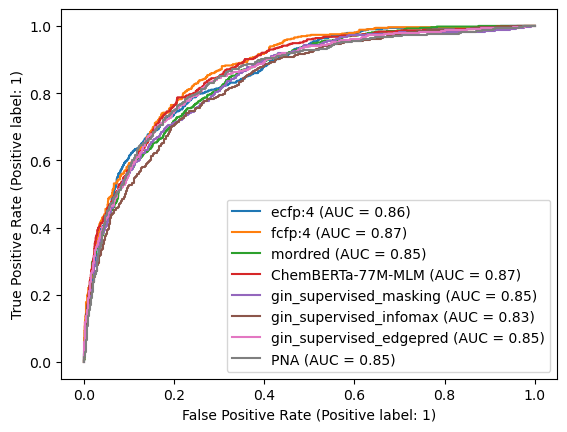

In [26]:
fig, ax = plt.subplots()
for name, preds in cv_results.predictions.items():
    y_test, y_score = preds
    RocCurveDisplay.from_predictions(y_test, y_score, name=name, ax=ax)
fig.savefig("notebooks/ROC-curves.png")

## Precision

In [61]:
precisions = []
methods = []
for name, preds in cv_results.predictions.items():
    y_test, y_score = preds
    methods.append(name)
    precisions.append(precision_score(y_test, [int(score > 0.5) for score in y_score]))

In [62]:
precisions_df = pd.DataFrame({"method": methods, "precision": precisions})
precisions_df

,method,precision
0,ecfp:4,0.703226
1,fcfp:4,0.703170
2,mordred,0.730769
3,ChemBERTa-77M-MLM,0.793860
4,gin_supervised_masking,0.762626
5,gin_supervised_infomax,0.717703
6,gin_supervised_edgepred,0.781553
7,PNA,0.603143


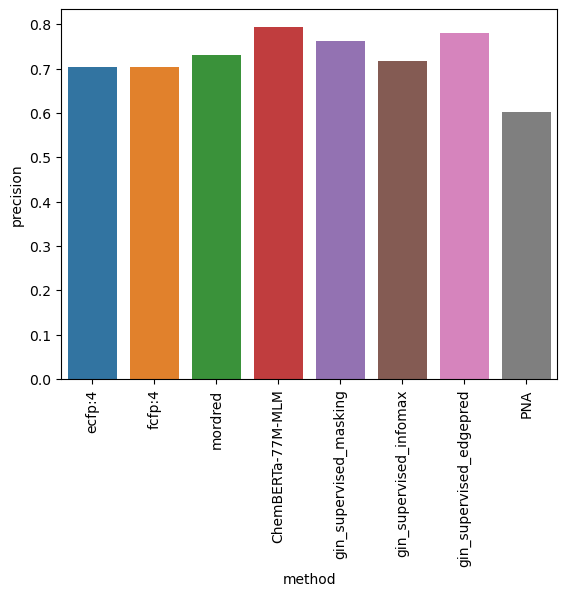

In [72]:
ax = sns.barplot(data=precisions_df, x="method", y="precision")
_=plt.xticks(rotation=90)
ax.figure.savefig("notebooks/precisions.png", bbox_inches='tight')

__Precision of the PNA model is much lower than the others__

## Recallfigure

In [65]:
recalls = []
methods = []
for name, preds in cv_results.predictions.items():
    y_test, y_score = preds
    methods.append(name)
    recalls.append(recall_score(y_test, [int(score > 0.5) for score in y_score]))

In [66]:
recalls_df = pd.DataFrame({"method": methods, "recall": recalls})
recalls_df

,method,recall
0,ecfp:4,0.413662
1,fcfp:4,0.462998
2,mordred,0.360531
3,ChemBERTa-77M-MLM,0.343454
4,gin_supervised_masking,0.286528
5,gin_supervised_infomax,0.284630
6,gin_supervised_edgepred,0.305503
7,PNA,0.582543


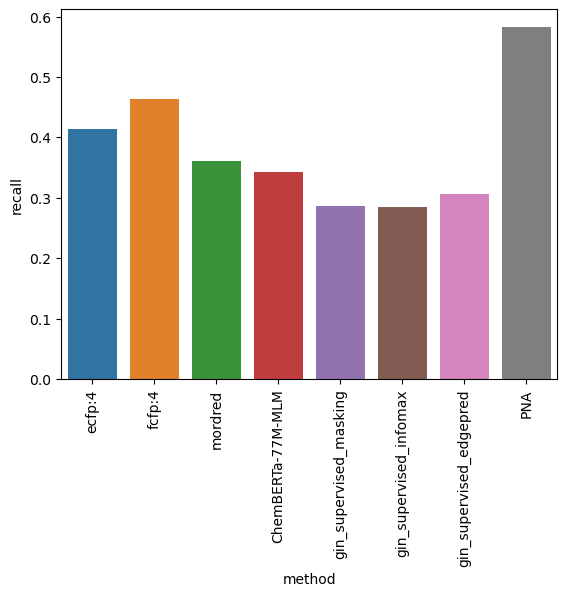

In [71]:
ax = sns.barplot(data=recalls_df, x="method", y="recall")
_=plt.xticks(rotation=90)
ax.figure.savefig("notebooks/recalls.png", bbox_inches='tight')

__Recall of the PNA model is much higher than the others__

## Calibration

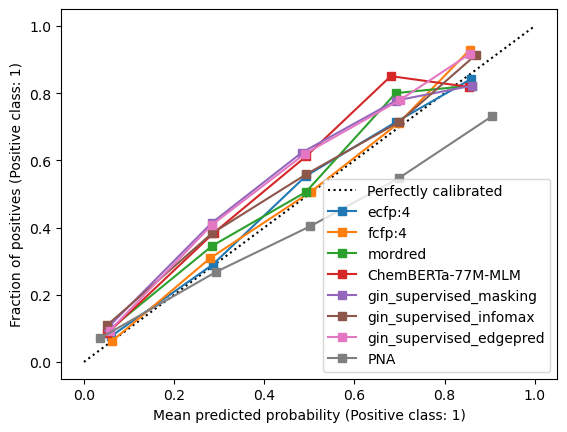

In [27]:
fig, ax = plt.subplots()
for name, preds in cv_results.predictions.items():
    y_test, y_score = preds
    display = CalibrationDisplay.from_predictions(y_test, y_score, ax=ax, name=name)
fig.savefig("notebooks/calibrations.png")

__PNA seems to be the least well calibrated classifier__